# Importing Libraries

### Libraries

In [68]:
import pandas as pd
import numpy as np
import warnings

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display            import Markdown

from sklearn.preprocessing      import LabelEncoder
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, KFold
from sklearn.metrics            import roc_auc_score, accuracy_score


### Auxiliary Functions and Configurations

In [71]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')

def func_LabelEncoder(df):
    return LabelEncoder().fit_transform(df)

def LazzyLabelEncoder(df, text=True):
    text_LazzyLabelEncoder = ''
    dicio_LazzyLabelEncoder = {}
    for i, j in enumerate(df.unique()):
        text_LazzyLabelEncoder += f'{i} - {j}\n '
        dicio_LazzyLabelEncoder[j] = i
    return text_LazzyLabelEncoder[:-2] if text==True else dicio_LazzyLabelEncoder

def df_informations(df):
    df_info = pd.DataFrame({'Not Null': df.notnull().count(),
                'Null': df.isnull().sum(),
                'Perce Null': df.isnull().sum() / len(df),
                'Dtype': df.dtypes,
                })

    df_dtype = pd.DataFrame(df_info['Dtype'].value_counts())
    df_dtype['Perce'] = round(df_dtype['Dtype'] / df_dtype['Dtype'].sum(), 2)

    text = f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns. From these, we have:'

    df_info = df_info.style.background_gradient(cmap='jet', subset=['Perce Null']).format({'Perce Null': '{:.2%}'})
    df_dtype = df_dtype.style.background_gradient(cmap='YlGn', subset=['Perce']).format({'Perce': '{:.2%}'})

    display(Markdown("<H3 style='text-align:left;float:lfet;'>Information about the Dataset"))
    display(Markdown(f'<H5> {text}'))
    display(df_info)
    display(Markdown("<H3 style='text-align:left;float:lfet;'>About Dtypes we have:"))
    display(df_dtype)

# Data Understanding

## Collect  Initial Data

In [48]:
df = pd.read_csv('bank_customer_churn_prediction.csv')
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Describe Data

The dataset collected from Kaggle (https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset?resource=download).

- customer_id, <font color='red'>unused variable</font>.
- credit_score, <font color='chartreuse'>used as input</font>.
- country, <font color='chartreuse'>used as input</font>.
- gender, <font color='chartreuse'>used as input</font>.
- age, <font color='chartreuse'>used as input</font>.
- tenure, <font color='chartreuse'>used as input</font>.
- balance, <font color='chartreuse'>used as input</font>.
- products_number, <font color='chartreuse'>used as input</font>.
- credit_card, <font color='chartreuse'>used as input</font>.
- active_member, <font color='chartreuse'>used as input</font>.
- estimated_salary, <font color='chartreuse'>used as input</font>.
- churn, <font color='orange'>used as the target</font>. 1 if the client has left the bank during some period or 0 if he/she has not.

Dropping the customer_id column

In [49]:
df = df.drop(['customer_id'], axis=1)

Data Information

In [5]:
df_informations(df)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 10000 rows and 11 columns. From these, we have:

,Not Null,Null,Perce Null,Dtype
credit_score,10000,0,0.00%,int64
country,10000,0,0.00%,object
gender,10000,0,0.00%,object
age,10000,0,0.00%,int64
tenure,10000,0,0.00%,int64
balance,10000,0,0.00%,float64
products_number,10000,0,0.00%,int64
credit_card,10000,0,0.00%,int64
active_member,10000,0,0.00%,int64
estimated_salary,10000,0,0.00%,float64


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Perce
int64,7,64.00%
object,2,18.00%
float64,2,18.00%


In [6]:
df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
credit_score,10000.00,650.53,96.65,350.00,432.00,584.00,652.00,718.00,850.00,850.00
age,10000.00,38.92,10.49,18.00,21.00,32.00,37.00,44.00,72.00,92.00
tenure,10000.00,5.01,2.89,0.00,0.00,3.00,5.00,7.00,10.00,10.00
balance,10000.00,76485.89,62397.41,0.00,0.00,0.00,97198.54,127644.24,185967.99,250898.09
products_number,10000.00,1.53,0.58,1.00,1.00,1.00,1.00,2.00,3.00,4.00
credit_card,10000.00,0.71,0.46,0.00,0.00,0.00,1.00,1.00,1.00,1.00
active_member,10000.00,0.52,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,1842.83,51002.11,100193.91,149388.25,198069.73,199992.48
churn,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,1.00,1.00


## Explore Data

In [ ]:
'''plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col], kde=True)
    plt.tight_layout()
    plt.plot()'''

: 

Transforming Categorical Features into Numerical

In [64]:
choice_columns = ['country', 'gender']
for i in df[choice_columns]:
    dicio_encoder = LazzyLabelEncoder(df=df[i], text=False)
    df[str(i) + '_encoder'] = df[i].apply(lambda x: dicio_encoder.get(x))

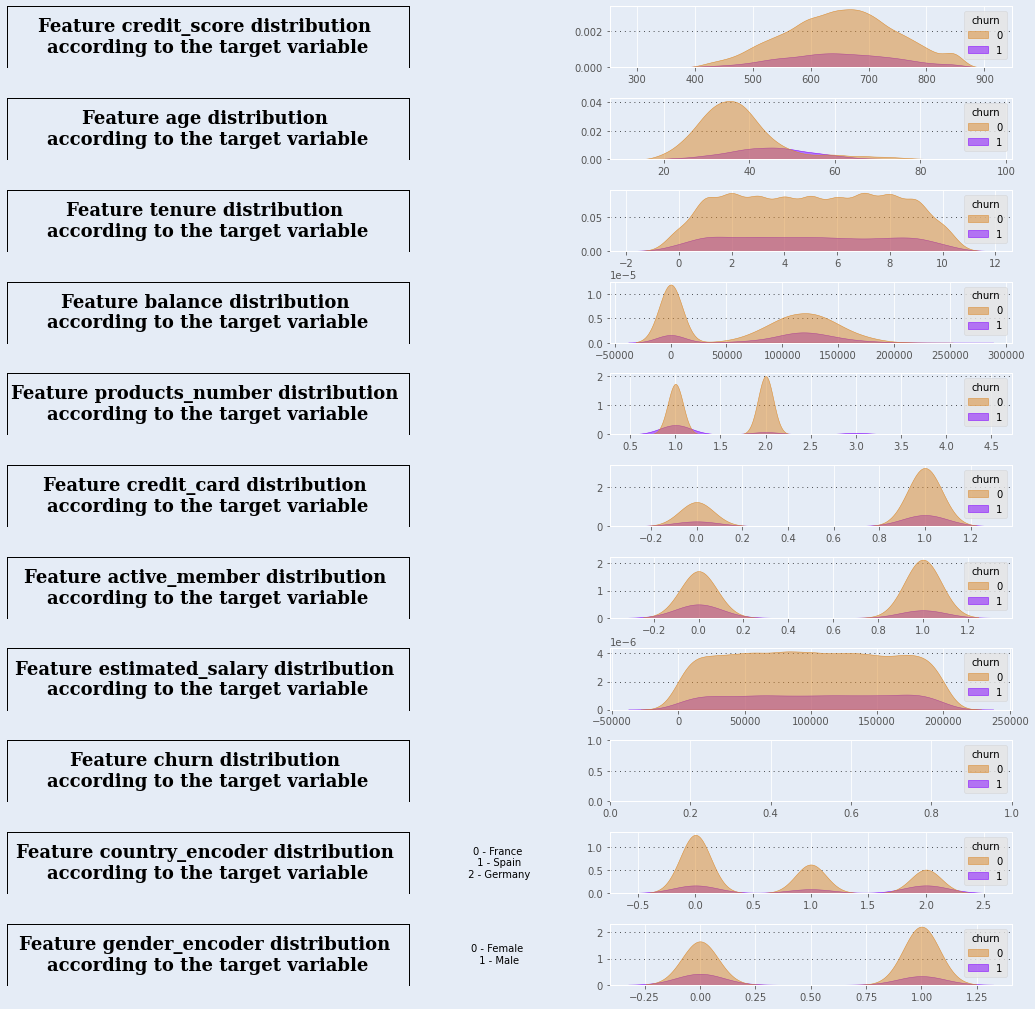

In [73]:
count_columns = df.select_dtypes(include= np.number).shape[1]

fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(count_columns, 2)
gs.update(wspace=0.5, hspace=0.5)

background_color = "#E5ECF6"

for i, j in enumerate(df.select_dtypes(include= np.number)):
    
    legends = ''
    legends = LazzyLabelEncoder(df=df[j[:-8] if '_encoder' in j else j], text=True) if '_encoder' in j else ''

    globals()['axe' + str(i)] = fig.add_subplot(gs[i, 0])
    globals()['axe' + str(i+1)] = fig.add_subplot(gs[i, 1])

    fig.patch.set_facecolor(background_color) 
    globals()['axe' + str(i)].set_facecolor(background_color) 
    globals()['axe' + str(i+1)].set_facecolor(background_color) 

    globals()['axe' + str(i)].text(0.5, 0.5, f"Feature {j} distribution \naccording to the target variable",
        horizontalalignment = 'center', verticalalignment = 'center',
        fontsize = 18, fontweight='bold', fontfamily='serif',
        color='#000000')

    globals()['axe' + str(i)].grid(False)
    globals()['axe' + str(i)].spines["bottom"].set_visible(False)
    globals()['axe' + str(i)].spines[['left', 'top', 'right']].set_color('#000000')
    globals()['axe' + str(i)].set_xticklabels([])
    globals()['axe' + str(i)].set_yticklabels([])
    globals()['axe' + str(i)].tick_params(left=False, bottom=False)
    globals()['axe' + str(i)].text(1.22, 0.5, legends,
        horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10
        )

    globals()['axe' + str(i+1)].grid(color='#000000', axis='y', zorder=0,  dashes=(1,5))
    sns.kdeplot(ax=globals()['axe' + str(i+1)], data=df, x=j, hue="churn", fill=True, palette=["#da8829", "#8000ff"], alpha=.5)
    globals()['axe' + str(i+1)].set_xlabel("")
    globals()['axe' + str(i+1)].set_ylabel("")


# Data Preparation

## Select Data

## Clean Data

## Construct Data

## Integrate Data

## Format Data

# Modeling

## Select Modeling Techniques

## Generate Test Design

## Build Model

## Assess Model

# Evaluation

## Evaluate Results

## Review Process

## Determine Next Steps

# Deployment

## Plan Deployment

## Plan Monitoring and Maintenance

## Produce Final Report

## Produce Final Report

## Review Project